# Test SemEval data
In which we test the utility of the SemEval toponym data ([here](https://competitions.codalab.org/competitions/19948#learn_the_details-data_resources)).

In [2]:
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

## Load data

In [77]:
import os
# import semeval_ffnn_baseline.utils
from importlib import reload
# reload(semeval_ffnn_baseline.utils)
from semeval_ffnn_baseline.utils import read_annotations
data_dir = '../../data/SemEval2018/dev_data/resolution/'
ann_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.ann')]
print('%d annotated files'%(len(ann_files)))
ann_data = []
for f in ann_files:
    try:
        f_data = read_annotations(f)
        f_num = os.path.basename(f).replace('.ann', '')
        # include filename data
        ann_data.append([f_num, f_data])
    except Exception as e:
        print('missing file %s'%(f))
        pass
print('print %d data sets'%(len(ann_data)))
total_ann_count = sum([len(d[1]) for d in ann_data])
print('%d total annotations'%(total_ann_count))
# ann_data = [read_annotations(f) for f in ann_files]

55 annotated files
Reading ../../data/SemEval2018/dev_data/resolution/2041090.ann
Reading ../../data/SemEval2018/dev_data/resolution/22470427.ann
Reading ../../data/SemEval2018/dev_data/resolution/PUB21490925.ann
Reading ../../data/SemEval2018/dev_data/resolution/16306617.ann
Reading ../../data/SemEval2018/dev_data/resolution/PUB20610681.ann
Reading ../../data/SemEval2018/dev_data/resolution/17652402.ann
Reading ../../data/SemEval2018/dev_data/resolution/PUB21173241.ann
Reading ../../data/SemEval2018/dev_data/resolution/PUB20631138.ann
Reading ../../data/SemEval2018/dev_data/resolution/18032512.ann
Reading ../../data/SemEval2018/dev_data/resolution/18704172.ann
Reading ../../data/SemEval2018/dev_data/resolution/1731092.ann
Reading ../../data/SemEval2018/dev_data/resolution/PUB20167132.ann
Reading ../../data/SemEval2018/dev_data/resolution/PUB21900171.ann
ERROR: Could not extract Lat Long parts T57 <latlong>38.62727, -90.19789</latlong><geoID>4407084</geoID><pop>319294</pop> in ../../da

In [88]:
import numpy as np
import re
ann_data_df = pd.concat([pd.Series([d_name, a.text, a.atype, a.geonameid, a.lat, a.lon, a.start, a.end]) for [d_name, d] in ann_data for a in d], axis=1).transpose()
ann_data_df.columns = ['docid', 'text', 'atype', 'geonames_ID', 'lat', 'lon', 'start', 'end']
# add doc+start+end col
ann_data_df.loc[:, 'doc_start_end'] = ann_data_df.apply(lambda x: '_'.join(x.loc[['docid', 'start', 'end']].astype(str).values), axis=1)
# remove bad points
ann_data_df = ann_data_df[~((ann_data_df.loc[:, 'lat']==0) & (ann_data_df.loc[:, 'lon']==0))]
# fix data
num_matcher = re.compile('-?[0-9]+\.[0-9]+|-?[0-9]+')
# ann_data_df.loc[:, 'lat'] = ann_data_df.loc[:, 'lat'].apply(lambda x: float(x))
def convert_lat_lon_num(x):
    if(type(x) is str):
        try:
            x_float = float(x)
        except Exception as e:
            if(num_matcher.search(x) is not None):
                x_float = float(num_matcher.search(x).group(0))
            else:
                x_float = np.inf
    return x_float
ann_data_df.loc[:, 'lat'] = ann_data_df.loc[:, 'lat'].apply(convert_lat_lon_num)
ann_data_df.loc[:, 'lon'] = ann_data_df.loc[:, 'lon'].apply(convert_lat_lon_num)
ann_data_df.loc[:, 'geonames_ID'] = ann_data_df.loc[:, 'geonames_ID'].apply(convert_lat_lon_num)
# get rid of double zeros
ann_data_df = ann_data_df[~((ann_data_df.loc[:, 'lon']==0)&
                            (ann_data_df.loc[:, 'lat']==0))]
# get rid of inf
ann_data_df = ann_data_df[~((ann_data_df.loc[:, 'lon'].apply(np.isinf))&
                            (ann_data_df.loc[:, 'lat'].apply(np.isinf)))]
# get rid of anything without GeoNames ID
ann_data_df = ann_data_df[~ann_data_df.loc[:, 'geonames_ID'].apply(np.isinf)]
ann_data_df.loc[:, 'geonames_ID'] = ann_data_df.loc[:, 'geonames_ID'].astype(int)
print(ann_data_df.shape)
display(ann_data_df.head())

(1691, 9)


,docid,text,atype,geonames_ID,lat,lon,start,end,doc_start_end
0,2041090,Europe,LOC,6255148,48.69096,9.14062,2170,2176,2041090_2170_2176
1,2041090,Champaign,LOC,4887163,40.14008,-88.19919,8800,8809,2041090_8800_8809
2,2041090,China,LOC,1814991,35.00000,105.00000,9613,9618,2041090_9613_9618
3,2041090,Southeast Asia,LOC,6942346,12.38293,103.00781,10933,10947,2041090_10933_10947
4,2041090,Japan,LOC,1861060,36.00000,138.00000,10957,10962,2041090_10957_10962


Let's plot the data distribution!!

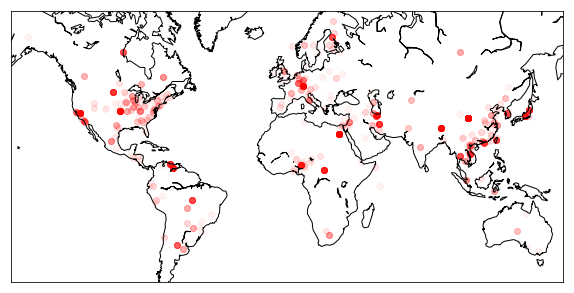

In [89]:
from mpl_toolkits.basemap import Basemap
x_bounds = [-160, 160]
y_bounds = [-50, 70]
plt.figure(figsize=(10, 5))
geo_map = Basemap(llcrnrlon=x_bounds[0], llcrnrlat=y_bounds[0], 
                  urcrnrlon=x_bounds[1], urcrnrlat=y_bounds[1],
                  projection='merc')
x, y = geo_map(x=ann_data_df.loc[:, 'lon'].values, y=ann_data_df.loc[:, 'lat'].values)
geo_map.drawcoastlines()
geo_map.scatter(x, y, c='r', alpha=0.05)
plt.show()

As expected, mostly country-level (center of Asia, China, US, Europe, etc.).

Let's break this down by subtype according to GeoNames (all non-country toponyms).

In [90]:
# geonames_data = pd.read_csv('/hg190/corpora/GeoNames/allCountriesSimplified.tsv',
#                             sep='\t', index_col=False, 
#                             usecols=['geonames_ID', 'name', 'feature_class', 'feature_code'])

In [91]:
ann_data_geo_df = pd.merge(ann_data_df, geonames_data, on='geonames_ID', how='inner')
display(ann_data_geo_df.head())

,docid,text,atype,geonames_ID,lat,lon,start,end,doc_start_end,name,feature_class,feature_code,name_regex
0,2041090,Europe,LOC,6255148,48.69096,9.14062,2170,2176,2041090_2170_2176,Europe,L,CONT,europe|chau au|eiropa|\Ðµ\Ð²\Ñ\Ð¾\Ð¿\Ð°|\Ñ\Ð...
1,2041090,Europe,LOC,6255148,48.69096,9.14062,11412,11418,2041090_11412_11418,Europe,L,CONT,europe|chau au|eiropa|\Ðµ\Ð²\Ñ\Ð¾\Ð¿\Ð°|\Ñ\Ð...
2,2041090,Europe,LOC,6255148,48.69096,9.14062,34789,34795,2041090_34789_34795,Europe,L,CONT,europe|chau au|eiropa|\Ðµ\Ð²\Ñ\Ð¾\Ð¿\Ð°|\Ñ\Ð...
3,2041090,Europe,LOC,6255148,48.69096,9.14062,45519,45525,2041090_45519_45525,Europe,L,CONT,europe|chau au|eiropa|\Ðµ\Ð²\Ñ\Ð¾\Ð¿\Ð°|\Ñ\Ð...
4,2041090,Europe,LOC,6255148,48.69096,9.14062,45824,45830,2041090_45824_45830,Europe,L,CONT,europe|chau au|eiropa|\Ðµ\Ð²\Ñ\Ð¾\Ð¿\Ð°|\Ñ\Ð...


In [92]:
# remove continents
ann_data_geo_df_clean = ann_data_geo_df[~((ann_data_geo_df.loc[:, 'feature_class'] == 'L') &
                                          (ann_data_geo_df.loc[:, 'feature_code'] == 'CONT'))]
print(ann_data_geo_df_clean.shape[0])
# remove countries
ann_data_geo_df_clean = ann_data_geo_df_clean[~((ann_data_geo_df_clean.loc[:, 'feature_class'] == 'A') &
                                                (ann_data_geo_df_clean.loc[:, 'feature_code'] == 'PCLI'))]
print(ann_data_geo_df_clean.shape[0])
# remove regions
ann_data_geo_df_clean = ann_data_geo_df_clean[~((ann_data_geo_df_clean.loc[:, 'feature_class'] == 'L') &
                                                (ann_data_geo_df_clean.loc[:, 'feature_code'] == 'RGN'))]
print(ann_data_geo_df_clean.shape[0])
# remove administrative regions
ann_data_geo_df_clean = ann_data_geo_df_clean[~((ann_data_geo_df_clean.loc[:, 'feature_class'] == 'A') &
                                                (ann_data_geo_df_clean.loc[:, 'feature_code'] == 'ADM1'))]
print(ann_data_geo_df_clean.shape[0])

1510
690
645
251


In [93]:
display(ann_data_geo_df_clean.head(20))

,docid,text,atype,geonames_ID,lat,lon,start,end,doc_start_end,name,feature_class,feature_code,name_regex
61,2041090,Champaign,LOC,4887163,40.14008,-88.19919,8800,8809,2041090_8800_8809,Champaign County,A,ADM2,champaign county|okrug shampejn|condado han ch...
62,1731092,Champaign,LOC,4887163,40.14008,-88.19919,9134,9143,1731092_9134_9143,Champaign County,A,ADM2,champaign county|okrug shampejn|condado han ch...
321,2041090,Astrakhan,LOC,580497,46.34968,48.04076,18340,18349,2041090_18340_18349,Astrakhan,P,PPLA,astrakhan|\Ê¼strhn|\Ð°\Ñ\Ñ\Ð°\Ñ\Ñ \Ð°\Ð°\Ð½...
531,22470427,Pipersville,LOC,5206344,40.42538,-75.13934,11050,11061,22470427_11050_11061,Pipersville,P,PPL,pipersville|keichlines tavern|pipers tavern
533,22470427,Winnipeg,LOC,6183235,49.88440,-97.14704,11651,11659,22470427_11651_11659,Winnipeg,P,PPLA,winnipeg|uinipeg|\Î³\Î¿\Ï \Î¯\Î½\Î¹\Ï\Îµ\Î³\Î...
534,22470427,Winnipeg,LOC,6183235,49.88440,-97.14704,12166,12174,22470427_12166_12174,Winnipeg,P,PPLA,winnipeg|uinipeg|\Î³\Î¿\Ï \Î¯\Î½\Î¹\Ï\Îµ\Î³\Î...
535,22470427,Austin,LOC,4671654,30.26715,-97.74306,13224,13230,22470427_13224_13230,Austin,P,PPLA,austin|ostins|austino|\à¤ \à¤¸\à¥\à¤\à¤¿\à¤¨...
536,23441208,Austin,LOC,4671654,30.26715,-97.74306,54603,54609,23441208_54603_54609,Austin,P,PPLA,austin|ostins|austino|\à¤ \à¤¸\à¥\à¤\à¤¿\à¤¨...
537,PUB20202440,Austin,LOC,4671654,30.26715,-97.74306,6100,6106,PUB20202440_6100_6106,Austin,P,PPLA,austin|ostins|austino|\à¤ \à¤¸\à¥\à¤\à¤¿\à¤¨...
538,22470427,Gaithersburg,LOC,4355843,39.14344,-77.20137,16668,16680,22470427_16668_16680,Gaithersburg,P,PPL,gaithersburg|gejzehrsburg|\Ú¯\Û\Øª\Ø±\Ø²\Ø¨\Ø...


Let's map out what is left.

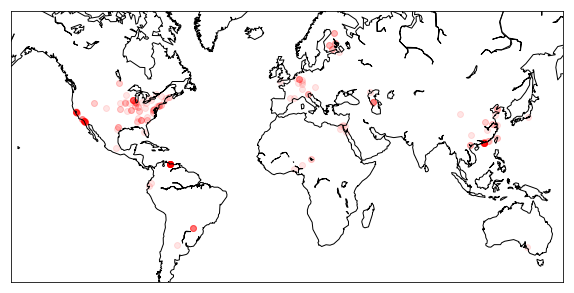

In [94]:
x_bounds = [-160, 160]
y_bounds = [-50, 70]
plt.figure(figsize=(10, 5))
geo_map = Basemap(llcrnrlon=x_bounds[0], llcrnrlat=y_bounds[0], 
                  urcrnrlon=x_bounds[1], urcrnrlat=y_bounds[1],
                  projection='merc')
x, y = geo_map(x=ann_data_geo_df_clean.loc[:, 'lon'].values, y=ann_data_geo_df_clean.loc[:, 'lat'].values)
geo_map.drawcoastlines()
geo_map.scatter(x, y, c='r', alpha=0.1)
plt.show()

## Generate SemEval candidates
Let's go through the motions and generate candidates for the SemEval candidates to try to resolve.

In [102]:
import re
# geonames_data = pd.read_csv('/hg190/corpora/GeoNames/allCountriesSimplified.tsv', sep='\t', index_col=False)
# # add regexes
# geonames_name_data = pd.read_csv('/hg190/corpora/GeoNames/geonames_clean_combined_names.tsv', sep='\t', index_col=False, encoding='latin-1')
# geonames_data = pd.merge(geonames_data, geonames_name_data, on='geonames_ID', how='inner')
geonames_data = geonames_data[~geonames_data.loc[:, 'name_regex'].apply(lambda x: np.isnan(x) if type(x) is float else False)]
# compile regexes
geonames_data.loc[:, 'name_regex'] = geonames_data.loc[:, 'name_regex'].apply(lambda x: '|'.join((map(lambda y: '^%s$'%(y), x.split('|')))))
geonames_data.loc[:, 'name_regex'] = geonames_data.loc[:, 'name_regex'].apply(re.compile)

In [108]:
import sys
module_path = os.path.abspath(os.path.join('../models'))
if(module_path not in sys.path):
    sys.path.append(module_path)
from data_helpers import normalize_str
import models.model_helpers
reload(models.model_helpers)
from models.model_helpers import generate_candidates_simple
ann_data_geo_df_clean.loc[:, 'text_norm'] = ann_data_geo_df_clean.loc[:, 'text'].apply(normalize_str)
topo_name_col = 'text_norm'
topo_doc_col = 'doc_start_end'
semeval_candidates = generate_candidates_simple(ann_data_geo_df_clean, geonames_data, 
                                                topo_name_col=topo_name_col, topo_doc_col=topo_doc_col, 
                                                gazetteer_name_col='name_regex')

NameError: name 'normalize_str' is not defined